# GAIN with Weight Sharing

## Preparation

In [1]:
import tensorflow as tf
import numpy as np
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Data generation
raw_data = np.loadtxt("https://raw.githubusercontent.com/priyasam9/Ensembel-GAN/master/Credit_Card.csv", delimiter=",",skiprows=1)

In [3]:
# Split Data into four pieces
full_size = len(raw_data)
n_subsets = 4
sub_size = full_size // n_subsets

subsets = []
for k in range(4):
    subsets.append(raw_data[k*sub_size:(k+1)*sub_size, k:k+21])
    
print("Split data into", n_subsets, "subsets. Size of one subset:", sub_size)

Split data into 4 subsets. Size of one subset: 7500


## Initial Step: Build GAIN on the first subset

In [4]:
# Apply GAIN on the first dataset
Data = subsets[0]
# Data = raw_data

In [5]:
#%% System Parameters
# 1. Mini batch size
mb_size = 128
# 2. Missing rate
p_miss = 0.2
# 3. Hint rate
p_hint = 0.9
# 4. Loss Hyperparameters
alpha = 10
# 5. Train Rate
train_rate = 0.8

# Parameters
No = len(Data)
Dim = len(Data[0,:])

# Hidden state dimensions
H_Dim1 = Dim
H_Dim2 = Dim

print(Dim)

21


In [6]:
# Normalization (0 to 1)
Min_Val = np.zeros(Dim)
Max_Val = np.zeros(Dim)

for i in range(Dim):
    Min_Val[i] = np.min(Data[:,i])
    Data[:,i] = Data[:,i] - np.min(Data[:,i])
    Max_Val[i] = np.max(Data[:,i])
    Data[:,i] = Data[:,i] / (np.max(Data[:,i]) + 1e-6)    

#%% Missing introducing
p_miss_vec = p_miss * np.ones((Dim,1)) 
   
Missing = np.zeros((No,Dim))

for i in range(Dim):
    A = np.random.uniform(0., 1., size = [len(Data),])
    B = A > p_miss_vec[i]
    Missing[:,i] = 1.*B

In [7]:
#%% Train Test Division    
   
idx = np.random.permutation(No)

Train_No = int(No * train_rate)
Test_No = No - Train_No
    
# Train / Test Features
trainX = Data[idx[:Train_No],:]
testX = Data[idx[Train_No:],:]

# Train / Test Missing Indicators
trainM = Missing[idx[:Train_No],:]
testM = Missing[idx[Train_No:],:]

In [8]:
#%% Necessary Functions

# 1. Xavier Initialization Definition
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape = size, stddev = xavier_stddev)
    
# Hint Vector Generation
def sample_M(m, n, p):
    A = np.random.uniform(0., 1., size = [m, n])
    B = A > p
    C = 1.*B
    return C

## GAIN Model
- Generator
- Discriminator
- Hint Mechanism

In [9]:
#%% GAIN Architecture   
   
#%% 1. Input Placeholders
# 1.1. Data Vector
X = tf.placeholder(tf.float32, shape = [None, Dim])
# 1.2. Mask Vector 
M = tf.placeholder(tf.float32, shape = [None, Dim])
# 1.3. Hint vector
H = tf.placeholder(tf.float32, shape = [None, Dim])
# 1.4. X with missing values
New_X = tf.placeholder(tf.float32, shape = [None, Dim])

In [10]:
#%% 2. Discriminator
D_W1 = tf.Variable(xavier_init([Dim*2, H_Dim1]), name="D_W1")     # Data + Hint as inputs
D_b1 = tf.Variable(tf.zeros(shape = [H_Dim1]), name="D_b1")

#D_W2 = tf.Variable(xavier_init([H_Dim1, H_Dim2]), name="D_W2")
D_W2 = tf.Variable(xavier_init([21, 21]), name="D_W2")
#D_b2 = tf.Variable(tf.zeros(shape = [H_Dim2]), name="D_b2")
D_b2 = tf.Variable(tf.zeros(shape = [21]), name="D_b2")

#D_W3 = tf.Variable(xavier_init([H_Dim2, Dim]), name="D_W3")
D_W3 = tf.Variable(xavier_init([21, Dim]), name="D_W3")
D_b3 = tf.Variable(tf.zeros(shape = [Dim]), name="D_b3")       # Output is multi-variate

theta_D = [D_W1, D_W2, D_W3, D_b1, D_b2, D_b3]

In [11]:
#%% 3. Generator
G_W1 = tf.Variable(xavier_init([Dim*2, H_Dim1]), name="G_W1")     # Data + Mask as inputs (Random Noises are in Missing Components)
G_b1 = tf.Variable(tf.zeros(shape = [H_Dim1]), name="G_b1")

#G_W2 = tf.Variable(xavier_init([H_Dim1, H_Dim2]), name="G_W2")
G_W2 = tf.Variable(xavier_init([21, 21]), name="G_W2")
#G_b2 = tf.Variable(tf.zeros(shape = [H_Dim2]), name="G_b2")
G_b2 = tf.Variable(tf.zeros(shape = [21]), name="G_b2")

#G_W3 = tf.Variable(xavier_init([H_Dim2, Dim]), name="G_W3")
G_W3 = tf.Variable(xavier_init([21, Dim]), name="G_W3")
G_b3 = tf.Variable(tf.zeros(shape = [Dim]), name="G_b3")

theta_G = [G_W1, G_W2, G_W3, G_b1, G_b2, G_b3]

In [12]:
#%% GAIN Function

#%% 1. Generator
def generator(new_x,m):
    inputs = tf.concat(axis = 1, values = [new_x,m])  # Mask + Data Concatenate
    G_h1 = tf.nn.relu(tf.matmul(inputs, G_W1) + G_b1)
    G_h2 = tf.nn.relu(tf.matmul(G_h1, G_W2) + G_b2)   
    G_prob = tf.nn.sigmoid(tf.matmul(G_h2, G_W3) + G_b3) # [0,1] normalized Output
    
    return G_prob
    
#%% 2. Discriminator
def discriminator(new_x, h):
    inputs = tf.concat(axis = 1, values = [new_x,h])  # Hint + Data Concatenate
    D_h1 = tf.nn.relu(tf.matmul(inputs, D_W1) + D_b1)  
    D_h2 = tf.nn.relu(tf.matmul(D_h1, D_W2) + D_b2)
    D_logit = tf.matmul(D_h2, D_W3) + D_b3
    D_prob = tf.nn.sigmoid(D_logit)  # [0,1] Probability Output
    
    return D_prob

In [13]:
#%% 3. Other functions
# Random sample generator for Z
def sample_Z(m, n):
    return np.random.uniform(0., 0.01, size = [m, n])        

# Mini-batch generation
def sample_idx(m, n):
    A = np.random.permutation(m)
    idx = A[:n]
    return idx

In [14]:
#%% Structure
# Generator
G_sample = generator(New_X,M)

# Combine with original data
Hat_New_X = New_X * M + G_sample * (1-M)

# Discriminator
D_prob = discriminator(Hat_New_X, H)

#%% Loss
D_loss1 = -tf.reduce_mean(M * tf.log(D_prob + 1e-8) + (1-M) * tf.log(1. - D_prob + 1e-8)) 
G_loss1 = -tf.reduce_mean((1-M) * tf.log(D_prob + 1e-8))
MSE_train_loss = tf.reduce_mean((M * New_X - M * G_sample)**2) / tf.reduce_mean(M)

D_loss = D_loss1
G_loss = G_loss1 + alpha * MSE_train_loss 

#%% MSE Performance metric
MSE_test_loss = tf.reduce_mean(((1-M) * X - (1-M)*G_sample)**2) / tf.reduce_mean(1-M)

#%% Solver
D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list=theta_D)
G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=theta_G)

In [15]:
# Sessions

sess = tf.Session()
sess.run(tf.global_variables_initializer())

#%% Iterations
train_losses = []
test_losses = []

#%% Start Iterations

for it in tqdm(range(1000)):    
    
    #%% Inputs
    mb_idx = sample_idx(Train_No, mb_size)
    X_mb = trainX[mb_idx,:]  
    
    Z_mb = sample_Z(mb_size, Dim) 
#     M_mb = trainM[mb_idx,:]  
    M_mb = trainM[:mb_size, :]
    H_mb1 = sample_M(mb_size, Dim, 1-p_hint)
    H_mb = M_mb * H_mb1
    
    New_X_mb = M_mb * X_mb + (1-M_mb) * Z_mb  # Missing Data Introduce
    
    _, D_loss_curr = sess.run([D_solver, D_loss1], feed_dict = {M: M_mb, New_X: New_X_mb, H: H_mb})
    _, G_loss_curr, MSE_train_loss_curr, MSE_test_loss_curr = sess.run([G_solver, G_loss1, MSE_train_loss, MSE_test_loss],
                                                                       feed_dict = {X: X_mb, M: M_mb, New_X: New_X_mb, H: H_mb})
            
        
    #%% Intermediate Losses
#     if it % 100 == 0:
#         print('Iter: {}'.format(it))
#         print('Train_loss: {:.4}'.format(np.sqrt(MSE_train_loss_curr)))
#         print('Test_loss: {:.4}'.format(np.sqrt(MSE_test_loss_curr)))
#         print()
    train_losses.append(np.sqrt(MSE_train_loss_curr))
    test_losses.append(np.sqrt(MSE_test_loss_curr))
    
#%% Final Loss
   
Z_mb = sample_Z(Test_No, Dim) 
M_mb = testM
X_mb = testX
        
New_X_mb = M_mb * X_mb + (1-M_mb) * Z_mb  # Missing Data Introduce
    
MSE_final, Sample = sess.run([MSE_test_loss, G_sample], feed_dict = {X: testX, M: testM, New_X: New_X_mb})
        
print('Final Test RMSE: ' + str(np.sqrt(MSE_final)))


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 401.18it/s]


Final Test RMSE: 0.14657912


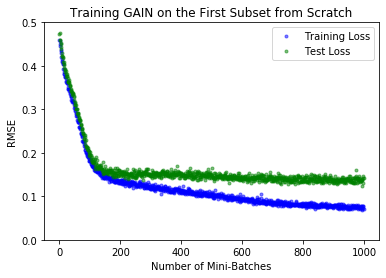

In [16]:
# Plot training curve
plt.plot(train_losses, 'b.', label="Training Loss", alpha=0.5)
plt.plot(test_losses, 'g.', label="Test Loss", alpha=0.5)
plt.title("Training GAIN on the First Subset from Scratch")
plt.xlabel("Number of Mini-Batches")
plt.ylabel("RMSE")
plt.ylim(0,0.5)
plt.legend()
plt.savefig("GAIN_subset1.png")
plt.show()

## Baseline: Train GAIN on the second subset from scratch

## Alternative Approach: Use previous GAIN weights to initialize GAIN2

In [17]:
# Store trained weights and biases
D_W1_values = sess.run(D_W1)
D_b1_values = sess.run(D_b1)
D_W2_values = sess.run(D_W2)
D_b2_values = sess.run(D_b2)
D_W3_values = sess.run(D_W3)
D_b3_values = sess.run(D_b3)
G_W1_values = sess.run(G_W1)
G_b1_values = sess.run(G_b1)
G_W2_values = sess.run(G_W2)
G_b2_values = sess.run(G_b2)
G_W3_values = sess.run(G_W3)
G_b3_values = sess.run(G_b3)

In [18]:
tf.reset_default_graph()
Data = subsets[1]

In [19]:
# Normalization (0 to 1)
Min_Val = np.zeros(Dim)
Max_Val = np.zeros(Dim)

for i in range(Dim):
    Min_Val[i] = np.min(Data[:,i])
    Data[:,i] = Data[:,i] - np.min(Data[:,i])
    Max_Val[i] = np.max(Data[:,i])
    Data[:,i] = Data[:,i] / (np.max(Data[:,i]) + 1e-6)    

#%% Missing introducing
p_miss_vec = p_miss * np.ones((Dim,1)) 
   
Missing = np.zeros((No,Dim))

for i in range(Dim):
    A = np.random.uniform(0., 1., size = [len(Data),])
    B = A > p_miss_vec[i]
    Missing[:,i] = 1.*B

In [20]:
#%% Train Test Division    
   
idx = np.random.permutation(No)

Train_No = int(No * train_rate)
Test_No = No - Train_No
    
# Train / Test Features
trainX = Data[idx[:Train_No],:]
testX = Data[idx[Train_No:],:]

# Train / Test Missing Indicators
trainM = Missing[idx[:Train_No],:]
testM = Missing[idx[Train_No:],:]

In [21]:
#%% GAIN Architecture   
   
#%% 1. Input Placeholders
# 1.1. Data Vector
X = tf.placeholder(tf.float32, shape = [None, Dim])
# 1.2. Mask Vector 
M = tf.placeholder(tf.float32, shape = [None, Dim])
# 1.3. Hint vector
H = tf.placeholder(tf.float32, shape = [None, Dim])
# 1.4. X with missing values
New_X = tf.placeholder(tf.float32, shape = [None, Dim])

## Weight sharing and bias sharing for GAIN2

In [22]:
'''
#D2_W1_np=(np.concatenate((D_W1_values[1:13],a,D_W1_values[14:26],a ),axis=0)).astype('float32')
D2_W1_np=D_W1_values.astype('float32')
D2_b1_np=D_b1_values.astype('float32')
#D2_W2_np=(np.concatenate((D_W2_values[1:13],a),axis=0)).astype('float32') 
D2_W2_np=(np.concatenate((D_W2_values,c,c1,c2),axis=1)).astype('float32')  
D2_b2_np=(np.concatenate((D_b2_values,b1,b2,b3),axis=0)).astype('float32')  
D2_W3_np=(np.concatenate((D_W3_values,a1,a2,a3),axis=0)).astype('float32')
D2_b3_np=D_b3_values.astype('float32')  
#G2_W1_np=(np.concatenate((G_W1_values[1:13],a4,G_W1_values[14:26],a ),axis=0)).astype('float32') 
#G2_b1_np=(np.concatenate((G_b1_values[1:13],b4),axis=0)).astype('float32')
G2_W1_np=G_W1_values.astype('float32')
G2_b1_np=G_b1_values.astype('float32')
G2_W2_np=(np.concatenate((G_W2_values,c3,c4,c5),axis=1)).astype('float32')
G2_b2_np=(np.concatenate((G_b2_values,b5,b6,b7),axis=0)).astype('float32') 
G2_W3_np=(np.concatenate((G_W3_values,a5,a6,a7),axis=0)).astype('float32') 
G2_b3_np=G_b3_values.astype('float32') 
'''
#Discriminator weights and biases
D2_W1_np=D_W1_values.astype('float32')
D2_b1_np=D_b1_values.astype('float32')
D2_W2_np1=D_W2_values.astype('float32')
#D2_W2_np2=np.concatenate((c,c1,c2),axis=1).astype('float32')
D2_b2_np1=D_b2_values.astype('float32')
#D2_b2_np2=np.concatenate((b1,b2,b3),axis=0).astype('float32')
D2_W3_np1=D_W3_values.astype('float32')
#D2_W3_np2=np.concatenate((a1,a2,a3),axis=0).astype('float32')
D2_b3_np=D_b3_values.astype('float32') 

#Generator weights and biases
G2_W1_np=G_W1_values.astype('float32')
G2_b1_np=G_b1_values.astype('float32')
G2_W2_np1=G_W2_values.astype('float32')
#G2_W2_np2=np.concatenate((c3,c4,c5),axis=1).astype('float32')
G2_b2_np1=G_b2_values.astype('float32')
#G2_b2_np2=np.concatenate((b5,b6,b7),axis=0).astype('float32')
G2_W3_np1=G_W3_values.astype('float32')
#G2_W3_np2=np.concatenate((a5,a6,a7),axis=0).astype('float32')
G2_b3_np=G_b3_values.astype('float32')

In [23]:
'''
G2_W1 = tf.get_variable("G2_W1", initializer=G2_W1_np) 
G2_b1 =tf.get_variable("G2_b1", initializer=G2_b1_np)

G2_W2=tf.get_variable("G2_W2", initializer=G2_W2_np)
G2_b2=tf.get_variable("G2_b2", initializer=G2_b2_np)

G2_W3=tf.get_variable("G2_W3", initializer=G2_W3_np)
G2_b3=tf.get_variable("G2_b3", initializer=G2_b3_np)
theta_G2 = [G2_W1, G2_W2, G2_W3, G2_b1, G2_b2, G2_b3]
'''
G2_W1=tf.get_variable("G2_W1", initializer=G2_W1_np)
G2_b1 =tf.get_variable("G2_b1", initializer=G2_b1_np)

G2_W21=tf.get_variable("G2_W21", initializer=G2_W2_np1)
#G2_W22=tf.get_variable("G2_W22", initializer=G2_W2_np2)
G2_W22=tf.Variable(xavier_init([21, 5]), name="G2_W2")
G2_b21=tf.get_variable("G2_b21", initializer=G2_b2_np1)
#G2_b22=tf.get_variable("G2_b22", initializer=G2_b2_np2)
G2_b22=tf.Variable(xavier_init([1, 5]), name="G2_b22")

G2_W31=tf.get_variable("G2_W31", initializer=G2_W3_np1)
#G2_W32=tf.get_variable("G2_W32", initializer=G2_W3_np2)
G2_W32=tf.Variable(xavier_init([5, 21]), name="G2_W32")
G2_b3=tf.get_variable("G2_b3", initializer=G2_b3_np)

theta_G2 = [G2_W22, G2_W32, G2_b22]
#theta_G2 = [G2_W1,G2_W21,G2_W22,G2_W31,G2_W32,G2_b1,G2_b21, G2_b22,G2_b3]

In [24]:
'''
D2_W1 = tf.get_variable("D2_W1", initializer=D2_W1_np)
D2_b1 =tf.get_variable("D2_b1", initializer=D2_b1_np)

D2_W2=tf.get_variable("D2_W2", initializer=D2_W2_np)
D2_b2=tf.get_variable("D2_b2", initializer=D2_b2_np)

D2_W3=tf.get_variable("D2_W3", initializer=D2_W3_np)
D2_b3=tf.get_variable("D2_b3", initializer=D2_b3_np)

theta_D2 = [D2_W1, D2_W2, D2_W3, D2_b1, D2_b2, D2_b3]
'''
D2_W1 = tf.get_variable("D2_W1", initializer=D2_W1_np)
D2_b1 =tf.get_variable("D2_b1", initializer=D2_b1_np)

D2_W21=tf.get_variable("D2_W21", initializer=D2_W2_np1)
#D2_W22=tf.get_variable("D2_W22", initializer=D2_W2_np2)
D2_W22=tf.Variable(xavier_init([21, 5]), name="D2_W2")
D2_b21=tf.get_variable("D2_b21", initializer=D2_b2_np1)
#D2_b22=tf.get_variable("D2_b22", initializer=D2_b2_np2)
D2_b22=tf.Variable(xavier_init([1, 5]), name="D2_b22")

D2_W31=tf.get_variable("D2_W31", initializer=D2_W3_np1)
#D2_W32=tf.get_variable("D2_W32", initializer=D2_W3_np2)
D2_W32=tf.Variable(xavier_init([5, 21]), name="D2_W32")
D2_b3=tf.get_variable("D2_b3", initializer=D2_b3_np)

theta_D2 = [ D2_W22, D2_W32, D2_b22]
#theta_D2 = [D2_W1,D2_W21,D2_W22,D2_W31,D2_W32,D2_b1,D2_b21, D2_b22,D2_b3]

In [25]:
#%% GAIN Function
'''
#%% 1. Generator
def generator(new_x,m):
    inputs = tf.concat(axis = 1, values = [new_x,m])  # Mask + Data Concatenate
    G2_h1 = tf.nn.relu(tf.matmul(inputs, G2_W1) + G2_b1)
    G2_h2 = tf.nn.relu(tf.matmul(G2_h1, G2_W2) + G2_b2)   
    G_prob = tf.nn.sigmoid(tf.matmul(G2_h2, G2_W3) + G2_b3) # [0,1] normalized Output
    
    return G_prob
    
#%% 2. Discriminator
def discriminator(new_x, h):
    inputs = tf.concat(axis = 1, values = [new_x,h])  # Hint + Data Concatenate
    D2_h1 = tf.nn.relu(tf.matmul(inputs, D2_W1) + D2_b1)  
    D2_h2 = tf.nn.relu(tf.matmul(D2_h1, D2_W2) + D2_b2)
    D2_logit = tf.matmul(D2_h2, D2_W3) + D2_b3
    D_prob = tf.nn.sigmoid(D2_logit)  # [0,1] Probability Output
    
    return D_prob
'''

#%% 1. Generator
def generator(new_x,m):
    inputs = tf.concat(axis = 1, values = [new_x,m])  # Mask + Data Concatenate
    G2_h1 = tf.nn.relu(tf.matmul(inputs, G2_W1) + G2_b1)
    G2_h2 = tf.nn.relu(tf.concat([(tf.matmul(G2_h1, G2_W21) + G2_b21),(tf.matmul(G2_h1, G2_W22) + G2_b22)],1))   
    G_prob = tf.nn.sigmoid(tf.matmul(G2_h2,tf.concat((G2_W31,G2_W32),0)) + G2_b3) # [0,1] normalized Output
    
    return G_prob
    
#%% 2. Discriminator
def discriminator(new_x, h):
    inputs = tf.concat(axis = 1, values = [new_x,h])  # Hint + Data Concatenate
    D2_h1 = tf.nn.relu(tf.matmul(inputs, D2_W1) + D2_b1)  
    D2_h2 = tf.nn.relu(tf.concat([(tf.matmul(D2_h1, D2_W21) + D2_b21),(tf.matmul(D2_h1, D2_W22) + D2_b22)],1)) 
    D2_logit = tf.matmul(D2_h2, tf.concat((D2_W31,D2_W32),0)) + D2_b3
    D_prob = tf.nn.sigmoid(D2_logit)  # [0,1] Probability Output
    
    return D_prob

In [26]:
#%% Structure
# Generator
G_sample = generator(New_X,M)
#print("G_sample",G_sample)
# Combine with original data
Hat_New_X = New_X * M + G_sample * (1-M)

# Discriminator
D_prob = discriminator(Hat_New_X, H)
#print("D_prob",D_prob)
#%% Loss
D_loss1 = -tf.reduce_mean(M * tf.log(D_prob + 1e-8) + (1-M) * tf.log(1. - D_prob + 1e-8)) 
G_loss1 = -tf.reduce_mean((1-M) * tf.log(D_prob + 1e-8))
MSE_train_loss = tf.reduce_mean((M * New_X - M * G_sample)**2) / tf.reduce_mean(M)

D_loss = D_loss1
G_loss = G_loss1 + alpha * MSE_train_loss 

#%% MSE Performance metric
MSE_test_loss = tf.reduce_mean(((1-M) * X - (1-M)*G_sample)**2) / tf.reduce_mean(1-M)

#%% Solver
D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list=theta_D2)
G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=theta_G2)

In [27]:
# Sessions
sess = tf.Session()
sess.run(tf.global_variables_initializer())

#%% Iterations
train_losses2 = []
test_losses2 = []

#%% Start Iterations
for it in tqdm(range(1000)):    
    
    #%% Inputs
    mb_idx = sample_idx(Train_No, mb_size)
    X_mb = trainX[mb_idx,:]  
    
    Z_mb = sample_Z(mb_size, Dim) 
#     M_mb = trainM[mb_idx,:]  
    M_mb = trainM[:mb_size, :]
    H_mb1 = sample_M(mb_size, Dim, 1-p_hint)
    H_mb = M_mb * H_mb1
    
    New_X_mb = M_mb * X_mb + (1-M_mb) * Z_mb  # Missing Data Introduce
    
    _, D_loss_curr = sess.run([D_solver, D_loss1], feed_dict = {M: M_mb, New_X: New_X_mb, H: H_mb})
    _, G_loss_curr, MSE_train_loss_curr, MSE_test_loss_curr = sess.run([G_solver, G_loss1, MSE_train_loss, MSE_test_loss],
                                                                       feed_dict = {X: X_mb, M: M_mb, New_X: New_X_mb, H: H_mb})
            
        
    #%% Intermediate Losses
#     if it % 100 == 0:
#         print('Iter: {}'.format(it))
#         print('Train_loss: {:.4}'.format(np.sqrt(MSE_train_loss_curr)))
#         print('Test_loss: {:.4}'.format(np.sqrt(MSE_test_loss_curr)))
#         print()
    train_losses2.append(np.sqrt(MSE_train_loss_curr))
    test_losses2.append(np.sqrt(MSE_test_loss_curr))
    
#%% Final Loss
    
Z_mb = sample_Z(Test_No, Dim) 
M_mb = testM
X_mb = testX
        
New_X_mb = M_mb * X_mb + (1-M_mb) * Z_mb  # Missing Data Introduce
    
MSE_final, Sample = sess.run([MSE_test_loss, G_sample], feed_dict = {X: testX, M: testM, New_X: New_X_mb})
        
print('Final Test RMSE: ' + str(np.sqrt(MSE_final)))

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 407.73it/s]


Final Test RMSE: 0.17392299


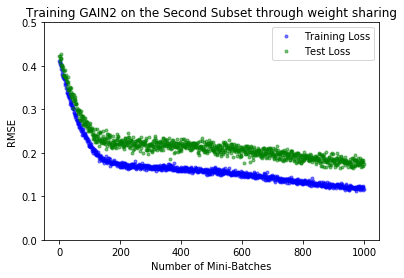

In [28]:
# Plot training curve
plt.plot(train_losses2, 'b.', label="Training Loss", alpha=0.5)
plt.plot(test_losses2, 'g.', label="Test Loss", alpha=0.5)
plt.title("Training GAIN2 on the Second Subset through weight sharing")
plt.xlabel("Number of Mini-Batches")
plt.ylabel("RMSE")
plt.ylim(0.0,0.5)
plt.legend()
plt.savefig("GAIN_subset2.png")
plt.show()

## GAIN3

In [29]:
# Store trained weights and biases
'''
D2_W1_values = sess.run(D2_W1)
D2_b1_values = sess.run(D2_b1)
D2_W2_values = sess.run(D2_W2)
D2_b2_values = sess.run(D2_b2)
D2_W3_values = sess.run(D2_W3)
D2_b3_values = sess.run(D2_b3)
G2_W1_values = sess.run(G2_W1)
G2_b1_values = sess.run(G2_b1)
G2_W2_values = sess.run(G2_W2)
G2_b2_values = sess.run(G2_b2)
G2_W3_values = sess.run(G2_W3)
G2_b3_values = sess.run(G2_b3)
'''
D2_W1_values = sess.run(D2_W1)
D2_b1_values = sess.run(D2_b1)
D2_W21_values=sess.run(D2_W21)
D2_W22_values=sess.run(D2_W22)
D2_b21_values=sess.run(D2_b21)
D2_b22_values=sess.run(D2_b22)
D2_W31_values=sess.run(D2_W31)
D2_W32_values=sess.run(D2_W32)
D2_b3_values=sess.run(D2_b3)

G2_W1_values = sess.run(G2_W1)
G2_b1_values = sess.run(G2_b1)
G2_W21_values=sess.run(G2_W21)
G2_W22_values=sess.run(G2_W22)
G2_b21_values=sess.run(G2_b21)
G2_b22_values=sess.run(G2_b22)
G2_W31_values=sess.run(G2_W31)
G2_W32_values=sess.run(G2_W32)
G2_b3_values=sess.run(G2_b3)


In [30]:
tf.reset_default_graph()
Data = subsets[2]

In [31]:
# Normalization (0 to 1)
Min_Val = np.zeros(Dim)
Max_Val = np.zeros(Dim)

for i in range(Dim):
    Min_Val[i] = np.min(Data[:,i])
    Data[:,i] = Data[:,i] - np.min(Data[:,i])
    Max_Val[i] = np.max(Data[:,i])
    Data[:,i] = Data[:,i] / (np.max(Data[:,i]) + 1e-6)    

#%% Missing introducing
p_miss_vec = p_miss * np.ones((Dim,1)) 
   
Missing = np.zeros((No,Dim))

for i in range(Dim):
    A = np.random.uniform(0., 1., size = [len(Data),])
    B = A > p_miss_vec[i]
    Missing[:,i] = 1.*B

In [32]:
#%% Train Test Division    
   
idx = np.random.permutation(No)

Train_No = int(No * train_rate)
Test_No = No - Train_No
    
# Train / Test Features
trainX = Data[idx[:Train_No],:]
testX = Data[idx[Train_No:],:]

# Train / Test Missing Indicators
trainM = Missing[idx[:Train_No],:]
testM = Missing[idx[Train_No:],:]

In [33]:
#%% GAIN Architecture   
   
#%% 1. Input Placeholders
# 1.1. Data Vector
X = tf.placeholder(tf.float32, shape = [None, Dim])
# 1.2. Mask Vector 
M = tf.placeholder(tf.float32, shape = [None, Dim])
# 1.3. Hint vector
H = tf.placeholder(tf.float32, shape = [None, Dim])
# 1.4. X with missing values
New_X = tf.placeholder(tf.float32, shape = [None, Dim])

In [34]:
'''
#D3_W1_np=(np.concatenate((D2_W1_values[1:13],a,D2_W1_values[14:26],a ),axis=0)).astype('float32')
#D3_b1_np=(np.concatenate((D2_b1_values[1:13],b),axis=0)).astype('float32')
D3_W1_np=D2_W1_values.astype('float32')
D3_b1_np=D2_b1_values.astype('float32')
D3_W2_np=(np.concatenate((D2_W2_values,c,c1,c2),axis=1)).astype('float32')  
D3_b2_np=(np.concatenate((D2_b2_values,b1,b2,b3),axis=0)).astype('float32')  
D3_W3_np=(np.concatenate((D2_W3_values,a1,a2,a3),axis=0)).astype('float32')  
D3_b3_np=D2_b3_values.astype('float32')  
#G3_W1_np=(np.concatenate((G2_W1_values[1:13],a4,G2_W1_values[14:26],a4 ),axis=0)).astype('float32') 
#G3_b1_np=(np.concatenate((G2_b1_values[1:13],b4),axis=0)).astype('float32')
G3_W1_np=G2_W1_values.astype('float32')
G3_b1_np=G2_b1_values.astype('float32')
G3_W2_np=(np.concatenate((G2_W2_values,c3,c4,c5),axis=1)).astype('float32') 
G3_b2_np=(np.concatenate((G2_b2_values,b5,b6,b7),axis=0)).astype('float32')  
G3_W3_np=(np.concatenate((G2_W3_values,a5,a6,a7),axis=0)).astype('float32')  
G3_b3_np=G2_b3_values.astype('float32') 
'''

#Discriminator weights and biases
D3_W1_np=D2_W1_values.astype('float32')
D3_b1_np=D2_b1_values.astype('float32')
D3_W2_np1=D2_W21_values.astype('float32')
D3_W2_np2=D2_W22_values.astype('float32')
#D3_W2_np3=np.concatenate((c,c1,c2),axis=1).astype('float32')
D3_b2_np1=D2_b21_values.astype('float32')
D3_b2_np2=D2_b22_values.astype('float32')
#D3_b2_np3=np.concatenate((b1,b2,b3),axis=0).astype('float32')
D3_W3_np1=D2_W31_values.astype('float32')
D3_W3_np2=D2_W32_values.astype('float32')
#D3_W3_np3=np.concatenate((a1,a2,a3),axis=0).astype('float32')
D3_b3_np=D2_b3_values.astype('float32') 

#Generator weights and biases
G3_W1_np=G2_W1_values.astype('float32')
G3_b1_np=G2_b1_values.astype('float32')
G3_W2_np1=G2_W21_values.astype('float32')
G3_W2_np2=G2_W22_values.astype('float32')
#G3_W2_np3=np.concatenate((c3,c4,c5),axis=1).astype('float32')
G3_b2_np1=G2_b21_values.astype('float32')
G3_b2_np2=G2_b22_values.astype('float32')
#G3_b2_np3=np.concatenate((b5,b6,b7),axis=0).astype('float32')
G3_W3_np1=G2_W31_values.astype('float32')
G3_W3_np2=G2_W32_values.astype('float32')
#G3_W3_np3=np.concatenate((a5,a6,a7),axis=0).astype('float32')
G3_b3_np=G2_b3_values.astype('float32')

In [35]:
'''
G3_W1 = tf.get_variable("G3_W1", initializer=G3_W1_np) 
G3_b1 =tf.get_variable("G3_b1", initializer=G3_b1_np)

G3_W2=tf.get_variable("G3_W2", initializer=G3_W2_np)
G3_b2=tf.get_variable("G3_b2", initializer=G3_b2_np)

G3_W3=tf.get_variable("G3_W3", initializer=G3_W3_np)
G3_b3=tf.get_variable("G3_b3", initializer=G3_b3_np)
theta_G3 = [G3_W2[:, -3:], G3_W3[-3:, :], G3_b2[:, -3:]]
'''


G3_W1=tf.get_variable("G3_W1", initializer=G3_W1_np)
G3_b1 =tf.get_variable("G3_b1", initializer=G3_b1_np)

G3_W21=tf.get_variable("G3_W21", initializer=G3_W2_np1)
G3_W22=tf.get_variable("G3_W22", initializer=G3_W2_np2)
#G3_W23=tf.get_variable("G3_W23", initializer=G3_W2_np3)
G3_W23=tf.Variable(xavier_init([21, 5]), name="G3_W23")
G3_b21=tf.get_variable("G3_b21", initializer=G3_b2_np1)
G3_b22=tf.get_variable("G3_b22", initializer=G3_b2_np2)
#G3_b23=tf.get_variable("G3_b23", initializer=G3_b2_np3)
G3_b23=tf.Variable(xavier_init([1, 5]), name="G3_b23")


G3_W31=tf.get_variable("G3_W31", initializer=G3_W3_np1)
G3_W32=tf.get_variable("G3_W32", initializer=G3_W3_np2)
#G3_W33=tf.get_variable("G3_W33", initializer=G3_W3_np3)
G3_W33=tf.Variable(xavier_init([5, 21]), name="G3_W33")
G3_b3=tf.get_variable("G3_b3", initializer=G3_b3_np)

theta_G3 = [G3_W23, G3_W33, G3_b23]
#theta_G3 = [G3_W1,G3_W21,G3_W22,G3_W23,G3_W31,G3_W32, G3_W33,G3_b1,G3_b21,G3_b22, G3_b23,G3_b3]

In [36]:
'''
D3_W1 = tf.get_variable("D3_W1", initializer=D3_W1_np)
D3_b1 =tf.get_variable("D3_b1", initializer=D3_b1_np)

D3_W2=tf.get_variable("D3_W2", initializer=D3_W2_np)
D3_b2=tf.get_variable("D3_b2", initializer=D3_b2_np)

D3_W3=tf.get_variable("D3_W3", initializer=D3_W3_np)
D3_b3=tf.get_variable("D3_b3", initializer=D3_b3_np)

#theta_D3 = [D3_W1, D3_W2, D3_W3, D3_b1, D3_b2, D3_b3]
theta_D3 = [D3_W2[:, -3:], D3_W3[-3:, :], D3_b2[:, -3:]]
'''
D3_W1 = tf.get_variable("D3_W1", initializer=D3_W1_np)
D3_b1 =tf.get_variable("D3_b1", initializer=D3_b1_np)

D3_W21=tf.get_variable("D3_W21", initializer=D3_W2_np1)
D3_W22=tf.get_variable("D3_W22", initializer=D3_W2_np2)
#D3_W23=tf.get_variable("D3_W23", initializer=D3_W2_np3)
D3_W23=tf.Variable(xavier_init([21, 5]), name="D3_W23")
D3_b21=tf.get_variable("D3_b21", initializer=D3_b2_np1)
D3_b22=tf.get_variable("D3_b22", initializer=D3_b2_np2)
#D3_b23=tf.get_variable("D3_b23", initializer=D3_b2_np3)
D3_b23=tf.Variable(xavier_init([1, 5]), name="D3_b23")

D3_W31=tf.get_variable("D3_W31", initializer=D3_W3_np1)
D3_W32=tf.get_variable("D3_W32", initializer=D3_W3_np2)
#D3_W33=tf.get_variable("D3_W33", initializer=D3_W3_np3)
D3_W33=tf.Variable(xavier_init([5, 21]), name="D3_W33")
D3_b3=tf.get_variable("D3_b3", initializer=D3_b3_np)
theta_D3 = [ D3_W23, D3_W33, D3_b23]
#theta_D3 = [D3_W1,D3_W21,D3_W22,D3_W23,D3_W31,D3_W32, D3_W33,D3_b1,D3_b21,D3_b22, D3_b23,D3_b3]

In [37]:
#%% GAIN Function
'''
#%% 1. Generator
def generator(new_x,m):
    inputs = tf.concat(axis = 1, values = [new_x,m])  # Mask + Data Concatenate
    G3_h1 = tf.nn.relu(tf.matmul(inputs, G3_W1) + G3_b1)
    G3_h2 = tf.nn.relu(tf.matmul(G3_h1, G3_W2) + G3_b2)   
    G_prob = tf.nn.sigmoid(tf.matmul(G3_h2, G3_W3) + G3_b3) # [0,1] normalized Output
    
    return G_prob
    
#%% 2. Discriminator
def discriminator(new_x, h):
    inputs = tf.concat(axis = 1, values = [new_x,h])  # Hint + Data Concatenate
    D3_h1 = tf.nn.relu(tf.matmul(inputs, D3_W1) + D3_b1)  
    D3_h2 = tf.nn.relu(tf.matmul(D3_h1, D3_W2) + D3_b2)
    D3_logit = tf.matmul(D3_h2, D3_W3) + D3_b3
    D_prob = tf.nn.sigmoid(D3_logit)  # [0,1] Probability Output
    
    return D_prob
'''

#%% 1. Generator
def generator(new_x,m):
    inputs = tf.concat(axis = 1, values = [new_x,m])  # Mask + Data Concatenate
    G3_h1 = tf.nn.relu(tf.matmul(inputs, G3_W1) + G3_b1)
    G3_h2 = tf.nn.relu(tf.concat([(tf.matmul(G3_h1, G3_W21) + G3_b21),(tf.matmul(G3_h1, G3_W22) + G3_b22),
                                 (tf.matmul(G3_h1, G3_W23) + G3_b23)],1))   
    G_prob = tf.nn.sigmoid(tf.matmul(G3_h2,tf.concat((G3_W31,G3_W32,G3_W33),0)) + G3_b3) # [0,1] normalized Output
    
    return G_prob
    
#%% 2. Discriminator
def discriminator(new_x, h):
    inputs = tf.concat(axis = 1, values = [new_x,h])  # Hint + Data Concatenate
    D3_h1 = tf.nn.relu(tf.matmul(inputs, D3_W1) + D3_b1)  
    D3_h2 = tf.nn.relu(tf.concat([(tf.matmul(D3_h1, D3_W21) + D3_b21),(tf.matmul(D3_h1, D3_W22) + D3_b22),
                                 (tf.matmul(D3_h1, D3_W23) + D3_b23)],1)) 
    D3_logit = tf.matmul(D3_h2, tf.concat((D3_W31,D3_W32,D3_W33),0)) + D3_b3
    D_prob = tf.nn.sigmoid(D3_logit)  # [0,1] Probability Output
    
    return D_prob

In [38]:
#%% Structure
# Generator
G_sample = generator(New_X,M)
#print("G_sample",G_sample)
# Combine with original data
Hat_New_X = New_X * M + G_sample * (1-M)

# Discriminator
D_prob = discriminator(Hat_New_X, H)
#print("D_prob",D_prob)
#%% Loss
D_loss1 = -tf.reduce_mean(M * tf.log(D_prob + 1e-8) + (1-M) * tf.log(1. - D_prob + 1e-8)) 
G_loss1 = -tf.reduce_mean((1-M) * tf.log(D_prob + 1e-8))
MSE_train_loss = tf.reduce_mean((M * New_X - M * G_sample)**2) / tf.reduce_mean(M)

D_loss = D_loss1
G_loss = G_loss1 + alpha * MSE_train_loss 

#%% MSE Performance metric
MSE_test_loss = tf.reduce_mean(((1-M) * X - (1-M)*G_sample)**2) / tf.reduce_mean(1-M)

#%% Solver
D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list=theta_D3)
G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=theta_G3)

In [39]:
# Sessions
import time
sess = tf.Session()
sess.run(tf.global_variables_initializer())

#%% Iterations
train_losses3 = []
test_losses3 = []
t2=time.time()
#%% Start Iterations
for it in tqdm(range(1000)):    
    
    #%% Inputs
    mb_idx = sample_idx(Train_No, mb_size)
    X_mb = trainX[mb_idx,:]  
    
    Z_mb = sample_Z(mb_size, Dim) 
#     M_mb = trainM[mb_idx,:]  
    M_mb = trainM[:mb_size, :]
    H_mb1 = sample_M(mb_size, Dim, 1-p_hint)
    H_mb = M_mb * H_mb1
    
    New_X_mb = M_mb * X_mb + (1-M_mb) * Z_mb  # Missing Data Introduce
    
    _, D_loss_curr = sess.run([D_solver, D_loss1], feed_dict = {M: M_mb, New_X: New_X_mb, H: H_mb})
    _, G_loss_curr, MSE_train_loss_curr, MSE_test_loss_curr = sess.run([G_solver, G_loss1, MSE_train_loss, MSE_test_loss],
                                                                       feed_dict = {X: X_mb, M: M_mb, New_X: New_X_mb, H: H_mb})
            
        
    #%% Intermediate Losses
#     if it % 100 == 0:
#         print('Iter: {}'.format(it))
#         print('Train_loss: {:.4}'.format(np.sqrt(MSE_train_loss_curr)))
#         print('Test_loss: {:.4}'.format(np.sqrt(MSE_test_loss_curr)))
#         print()
    train_losses3.append(np.sqrt(MSE_train_loss_curr))
    test_losses3.append(np.sqrt(MSE_test_loss_curr))
    
#%% Final Loss
t3=time.time()    
Z_mb = sample_Z(Test_No, Dim) 
M_mb = testM
X_mb = testX
        
New_X_mb = M_mb * X_mb + (1-M_mb) * Z_mb  # Missing Data Introduce
    
MSE_final, Sample = sess.run([MSE_test_loss, G_sample], feed_dict = {X: testX, M: testM, New_X: New_X_mb})
        
print('Final Test RMSE: ' + str(np.sqrt(MSE_final)))
print("Time cost: ",t3-t2)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 392.04it/s]


Final Test RMSE: 0.12140436
Time cost:  2.5529143810272217


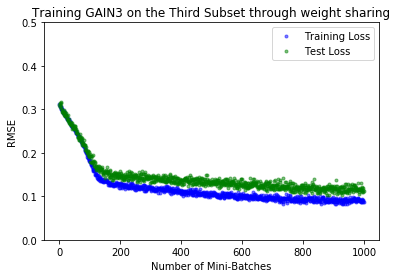

In [40]:
# Plot training curve
plt.plot(train_losses3, 'b.', label="Training Loss", alpha=0.5)
plt.plot(test_losses3, 'g.', label="Test Loss", alpha=0.5)
plt.title("Training GAIN3 on the Third Subset through weight sharing")
plt.xlabel("Number of Mini-Batches")
plt.ylabel("RMSE")
plt.ylim(0.0,0.5)
plt.legend()
plt.savefig("GAIN_subset3.png")
plt.show()

## GAIN4

In [41]:
# Store trained weights and biases
D3_W1_values = sess.run(D3_W1)
D3_b1_values = sess.run(D3_b1)
D3_W21_values = sess.run(D3_W21)
D3_W22_values = sess.run(D3_W22)
D3_W23_values = sess.run(D3_W23)
D3_b21_values = sess.run(D3_b21)
D3_b22_values = sess.run(D3_b22)
D3_b23_values = sess.run(D3_b23)
D3_W31_values = sess.run(D3_W31)
D3_W32_values = sess.run(D3_W32)
D3_W33_values = sess.run(D3_W33)
D3_b3_values = sess.run(D3_b3)

G3_W1_values = sess.run(G3_W1)
G3_b1_values = sess.run(G3_b1)
G3_W21_values = sess.run(G3_W21)
G3_W22_values = sess.run(G3_W22)
G3_W23_values = sess.run(G3_W23)
G3_b21_values = sess.run(G3_b21)
G3_b22_values = sess.run(G3_b22)
G3_b23_values = sess.run(G3_b23)
G3_W31_values = sess.run(G3_W31)
G3_W32_values = sess.run(G3_W32)
G3_W33_values = sess.run(G3_W33)
G3_b3_values = sess.run(G3_b3)

In [42]:
tf.reset_default_graph()
Data = subsets[3]

In [43]:
# Normalization (0 to 1)
Min_Val = np.zeros(Dim)
Max_Val = np.zeros(Dim)

for i in range(Dim):
    Min_Val[i] = np.min(Data[:,i])
    Data[:,i] = Data[:,i] - np.min(Data[:,i])
    Max_Val[i] = np.max(Data[:,i])
    Data[:,i] = Data[:,i] / (np.max(Data[:,i]) + 1e-6)    

#%% Missing introducing
p_miss_vec = p_miss * np.ones((Dim,1)) 
   
Missing = np.zeros((No,Dim))

for i in range(Dim):
    A = np.random.uniform(0., 1., size = [len(Data),])
    B = A > p_miss_vec[i]
    Missing[:,i] = 1.*B

In [44]:
#%% Train Test Division    
   
idx = np.random.permutation(No)

Train_No = int(No * train_rate)
Test_No = No - Train_No
    
# Train / Test Features
trainX = Data[idx[:Train_No],:]
testX = Data[idx[Train_No:],:]

# Train / Test Missing Indicators
trainM = Missing[idx[:Train_No],:]
testM = Missing[idx[Train_No:],:]

In [45]:
#%% GAIN Architecture   
   
#%% 1. Input Placeholders
# 1.1. Data Vector
X = tf.placeholder(tf.float32, shape = [None, Dim])
# 1.2. Mask Vector 
M = tf.placeholder(tf.float32, shape = [None, Dim])
# 1.3. Hint vector
H = tf.placeholder(tf.float32, shape = [None, Dim])
# 1.4. X with missing values
New_X = tf.placeholder(tf.float32, shape = [None, Dim])

In [46]:
#Discriminator weights and biases
D4_W1_np=D3_W1_values.astype('float32')
D4_b1_np=D3_b1_values.astype('float32')
D4_W2_np1=D3_W21_values.astype('float32')
D4_W2_np2=D3_W22_values.astype('float32')
D4_W2_np3=D3_W23_values.astype('float32')
#D4_W2_np4=np.concatenate((c,c1,c2),axis=1).astype('float32')
D4_b2_np1=D3_b21_values.astype('float32')
D4_b2_np2=D3_b22_values.astype('float32')
D4_b2_np3=D3_b23_values.astype('float32')
#D4_b2_np4=np.concatenate((b1,b2,b3),axis=0).astype('float32')
D4_W3_np1=D3_W31_values.astype('float32')
D4_W3_np2=D3_W32_values.astype('float32')
D4_W3_np3=D3_W33_values.astype('float32')
#D4_W3_np4=np.concatenate((a1,a2,a3),axis=0).astype('float32')
D4_b3_np=D3_b3_values.astype('float32') 

#Generator weights and biases
G4_W1_np=G3_W1_values.astype('float32')
G4_b1_np=G3_b1_values.astype('float32')
G4_W2_np1=G3_W21_values.astype('float32')
G4_W2_np2=G3_W22_values.astype('float32')
G4_W2_np3=G3_W23_values.astype('float32')
#G4_W2_np4=np.concatenate((c3,c4,c5),axis=1).astype('float32')
G4_b2_np1=G3_b21_values.astype('float32')
G4_b2_np2=G3_b22_values.astype('float32')
G4_b2_np3=G3_b23_values.astype('float32')
#G4_b2_np4=np.concatenate((b5,b6,b7),axis=0).astype('float32')
G4_W3_np1=G3_W31_values.astype('float32')
G4_W3_np2=G3_W32_values.astype('float32')
G4_W3_np3=G3_W33_values.astype('float32')
#G4_W3_np4=np.concatenate((a5,a6,a7),axis=0).astype('float32')
G4_b3_np=G3_b3_values.astype('float32')

In [47]:
G4_W1=tf.get_variable("G4_W1", initializer=G4_W1_np)
G4_b1 =tf.get_variable("G4_b1", initializer=G4_b1_np)

G4_W21=tf.get_variable("G4_W21", initializer=G4_W2_np1)
G4_W22=tf.get_variable("G4_W22", initializer=G4_W2_np2)
G4_W23=tf.get_variable("G4_W23", initializer=G4_W2_np3)
G4_W24=tf.Variable(xavier_init([21, 5]), name="G4_W24")
G4_b21=tf.get_variable("G4_b21", initializer=G4_b2_np1)
G4_b22=tf.get_variable("G4_b22", initializer=G4_b2_np2)
G4_b23=tf.get_variable("G4_b23", initializer=G4_b2_np3)
G4_b24=tf.Variable(xavier_init([1, 5]), name="G4_b24")


G4_W31=tf.get_variable("G4_W31", initializer=G4_W3_np1)
G4_W32=tf.get_variable("G4_W32", initializer=G4_W3_np2)
G4_W33=tf.get_variable("G4_W33", initializer=G4_W3_np3)
G4_W34=tf.Variable(xavier_init([5, 21]), name="G4_W34")
G4_b3=tf.get_variable("G4_b3", initializer=G4_b3_np)

theta_G4 = [G4_W24, G4_W34, G4_b24]
#theta_G4 = [G4_W1,G4_W21,G4_W22,G4_W23,G4_W24,G4_W31,G4_W32, G4_W33,G4_W34,G4_b1,G4_b21,G4_b22, G4_b23,G4_b24,G4_b3]

In [48]:
D4_W1 = tf.get_variable("D4_W1", initializer=D4_W1_np)
D4_b1 =tf.get_variable("D4_b1", initializer=D4_b1_np)

D4_W21=tf.get_variable("D4_W21", initializer=D4_W2_np1)
D4_W22=tf.get_variable("D4_W22", initializer=D4_W2_np2)
D4_W23=tf.get_variable("D4_W23", initializer=D4_W2_np3)
D4_W24=tf.Variable(xavier_init([21, 5]), name="D4_W24")
D4_b21=tf.get_variable("D4_b21", initializer=D4_b2_np1)
D4_b22=tf.get_variable("D4_b22", initializer=D4_b2_np2)
D4_b23=tf.get_variable("D4_b23", initializer=D4_b2_np3)
D4_b24=tf.Variable(xavier_init([1, 5]), name="D4_b24")

D4_W31=tf.get_variable("D4_W31", initializer=D4_W3_np1)
D4_W32=tf.get_variable("D4_W32", initializer=D4_W3_np2)
D4_W33=tf.get_variable("D4_W33", initializer=D4_W3_np3)
D4_W34=tf.Variable(xavier_init([5, 21]), name="D4_W34")
D4_b3=tf.get_variable("D3_b3", initializer=D3_b3_np)
theta_D4 = [ D4_W24, D4_W34, D4_b24]
#theta_D4 = [D4_W1,D4_W21,D4_W22,D4_W23,D4_W24,D4_W31,D4_W32, D4_W33,D4_W34,D4_b1,D4_b21,D4_b22, D4_b23,D4_b24,D4_b3]

In [49]:
#%% 1. Generator
def generator(new_x,m):
    inputs = tf.concat(axis = 1, values = [new_x,m])  # Mask + Data Concatenate
    G4_h1 = tf.nn.relu(tf.matmul(inputs, G4_W1) + G4_b1)
    G4_h2 = tf.nn.relu(tf.concat([(tf.matmul(G4_h1, G4_W21) + G4_b21),(tf.matmul(G4_h1, G4_W22) + G4_b22),
                                 (tf.matmul(G4_h1, G4_W23) + G4_b23),(tf.matmul(G4_h1, G4_W24) + G4_b24)],1))   
    G_prob = tf.nn.sigmoid(tf.matmul(G4_h2,tf.concat((G4_W31,G4_W32,G4_W33,G4_W34),0)) + G4_b3) # [0,1] normalized Output
    
    return G_prob
    
#%% 2. Discriminator
def discriminator(new_x, h):
    inputs = tf.concat(axis = 1, values = [new_x,h])  # Hint + Data Concatenate
    D4_h1 = tf.nn.relu(tf.matmul(inputs, D4_W1) + D4_b1)  
    D4_h2 = tf.nn.relu(tf.concat([(tf.matmul(D4_h1, D4_W21) + D4_b21),(tf.matmul(D4_h1, D4_W22) + D4_b22),
                                 (tf.matmul(D4_h1, D4_W23) + D4_b23),(tf.matmul(D4_h1, D4_W24) + D4_b24)],1)) 
    D4_logit = tf.matmul(D4_h2, tf.concat((D4_W31,D4_W32,D4_W33,D4_W34),0)) + D4_b3
    D_prob = tf.nn.sigmoid(D4_logit)  # [0,1] Probability Output
    
    return D_prob

In [50]:
#%% Structure
# Generator
G_sample = generator(New_X,M)
#print("G_sample",G_sample)
# Combine with original data
Hat_New_X = New_X * M + G_sample * (1-M)

# Discriminator
D_prob = discriminator(Hat_New_X, H)
#print("D_prob",D_prob)
#%% Loss
D_loss1 = -tf.reduce_mean(M * tf.log(D_prob + 1e-8) + (1-M) * tf.log(1. - D_prob + 1e-8)) 
G_loss1 = -tf.reduce_mean((1-M) * tf.log(D_prob + 1e-8))
MSE_train_loss = tf.reduce_mean((M * New_X - M * G_sample)**2) / tf.reduce_mean(M)

D_loss = D_loss1
G_loss = G_loss1 + alpha * MSE_train_loss 

#%% MSE Performance metric
MSE_test_loss = tf.reduce_mean(((1-M) * X - (1-M)*G_sample)**2) / tf.reduce_mean(1-M)

#%% Solver
D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list=theta_D4)
G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=theta_G4)

In [51]:
# Sessions
sess = tf.Session()
sess.run(tf.global_variables_initializer())

#%% Iterations
train_losses4 = []
test_losses4 = []
t4=time.time()
#%% Start Iterations
for it in tqdm(range(1000)):    
    
    #%% Inputs
    mb_idx = sample_idx(Train_No, mb_size)
    X_mb = trainX[mb_idx,:]  
    
    Z_mb = sample_Z(mb_size, Dim) 
#     M_mb = trainM[mb_idx,:]  
    M_mb = trainM[:mb_size, :]
    H_mb1 = sample_M(mb_size, Dim, 1-p_hint)
    H_mb = M_mb * H_mb1
    
    New_X_mb = M_mb * X_mb + (1-M_mb) * Z_mb  # Missing Data Introduce
    
    _, D_loss_curr = sess.run([D_solver, D_loss1], feed_dict = {M: M_mb, New_X: New_X_mb, H: H_mb})
    _, G_loss_curr, MSE_train_loss_curr, MSE_test_loss_curr = sess.run([G_solver, G_loss1, MSE_train_loss, MSE_test_loss],
                                                                       feed_dict = {X: X_mb, M: M_mb, New_X: New_X_mb, H: H_mb})
            
        
    #%% Intermediate Losses
#     if it % 100 == 0:
#         print('Iter: {}'.format(it))
#         print('Train_loss: {:.4}'.format(np.sqrt(MSE_train_loss_curr)))
#         print('Test_loss: {:.4}'.format(np.sqrt(MSE_test_loss_curr)))
#         print()
    train_losses4.append(np.sqrt(MSE_train_loss_curr))
    test_losses4.append(np.sqrt(MSE_test_loss_curr))
    
#%% Final Loss
t5=time.time()    
Z_mb = sample_Z(Test_No, Dim) 
M_mb = testM
X_mb = testX
        
New_X_mb = M_mb * X_mb + (1-M_mb) * Z_mb  # Missing Data Introduce
    
MSE_final, Sample = sess.run([MSE_test_loss, G_sample], feed_dict = {X: testX, M: testM, New_X: New_X_mb})
        
print('Final Test RMSE: ' + str(np.sqrt(MSE_final)))
print("Time cost: ",t5-t4)
sess.close()

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 398.43it/s]


Final Test RMSE: 0.15509333
Time cost:  2.512507677078247


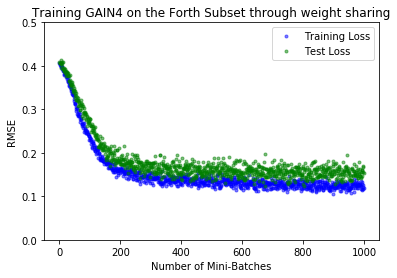

In [52]:
# Plot training curve
plt.plot(train_losses4, 'b.', label="Training Loss", alpha=0.5)
plt.plot(test_losses4, 'g.', label="Test Loss", alpha=0.5)
plt.title("Training GAIN4 on the Forth Subset through weight sharing")
plt.xlabel("Number of Mini-Batches")
plt.ylabel("RMSE")
plt.ylim(0.0,0.5)
plt.legend()
plt.savefig("GAIN_subset4.png")
plt.show()